# Install and Import Libraries

In [253]:
# install.packages("deSolve")
# install.packages("ggplot2")

In [254]:
# library(deSolve)
# library(ggplot2)

# Dual SEIRV model

In [331]:
# Parameters
params <- c(###YYYYES
  a = 0.5,         # Modifier for type A
  c = 0.2,         # Modifier for type T
  # beta_AA = 0.3,   # Transmission rate for A to A
  # beta_TA = 0.5,   # Transmission rate for T to A
  # beta_TT = 1.,   # Transmission rate for T to T
  # beta_AT = 0.2,   # Transmission rate for A to T
  nu = 0.1,        # Vaccination rate
  gamma = 0.12,     # Transition rate from exposed to infectious
  delta = 0.01,    # Recovery rate
  epsilon = 0.01   # Death rate
)

In [256]:
#Initialization

N0_A = 1000#
N0_T = 1000#
# Initial conditions
initial_state <- c(S_A = N0_A-11, E_A = 10, I_A = 1, R_A = 0, V_A = 0,
                   S_T = N0_T-60, E_T = 50, I_T = 10, R_T = 0, V_T = 0)

In [257]:
# Time sequence
num_years = 0.5
times <- seq(0, num_years*365, by = 1)

In [258]:
# Define the system's ODEs
seirv_model <- function(t, state, parameters) {
  with(as.list(c(state, parameters)), {
    N_A <- S_A + E_A + I_A + R_A + V_A
    N_T <- S_T + E_T + I_T + R_T + V_T
    N <- N_A + N_T
    I <- I_A + I_T

    lambda_A <- beta_AA * I_A / N_A * exp(-a * I / N) + beta_TA * I_T / N_T * exp(-c * I / N)
    lambda_T <- beta_TT * I_T / N_T + beta_AT * I_A / N_A * exp(-c * I / N)
    #Risk averse
    dS_A <- - (nu + lambda_A) * S_A
    dE_A <- lambda_A * S_A - gamma * E_A
    dI_A <- gamma * E_A - (delta + epsilon) * I_A
    dR_A <- delta * I_A
    dV_A <- nu * S_A
    #Risk tolerant
    dS_T <- - (nu + lambda_T) * S_T
    dE_T <- lambda_T * S_T - gamma * E_T
    dI_T <- gamma * E_T - (delta + epsilon) * I_T
    dR_T <- delta * I_T
    dV_T <- nu * S_T
    #Return value
    list(c(dS_A, dE_A, dI_A, dR_A, dV_A,
           dS_T, dE_T, dI_T, dR_T, dV_T))
  })
}

In [259]:
# Compute the solution of an ODEs
simEpidemic <- function(initial_state, timestep, model, params){
  ## Integration with
  ts <- data.frame(lsoda(
    y = initial_state,# Initial conditions for population
    times = timestep, # Timepoints for evaluation
    func = model,# Function to evaluate
    parms = params# Vector of parameters
  ))
  N = ts$P <- with(ts, (I_A+I_T)/(S_A+E_A+I_A+R_A+V_A+S_T+E_T+I_T+R_T+V_T))
  return(ts)
}

In [260]:
# Solve the system of differential equations
output_df = simEpidemic(initial_state, times, seirv_model, params)

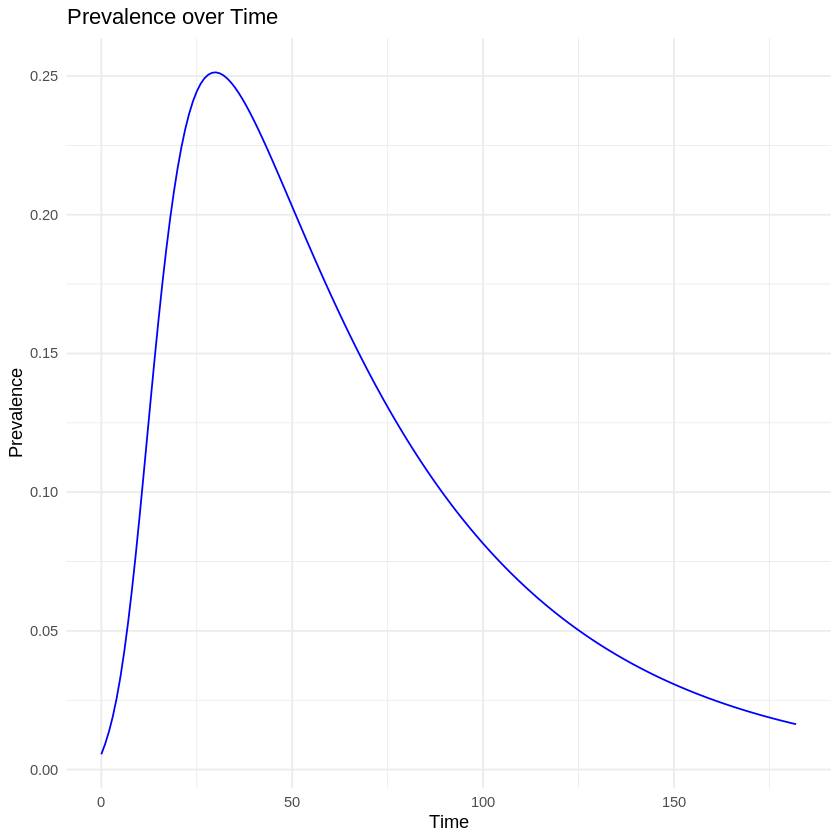

In [261]:
# Plot the prevalence
ggplot(data = output_df, aes(x = time, y = P)) +
  geom_line(color = "blue") +
  labs(title = "Prevalence over Time", x = "Time", y = "Prevalence") +
  theme_minimal()

# Data simulation

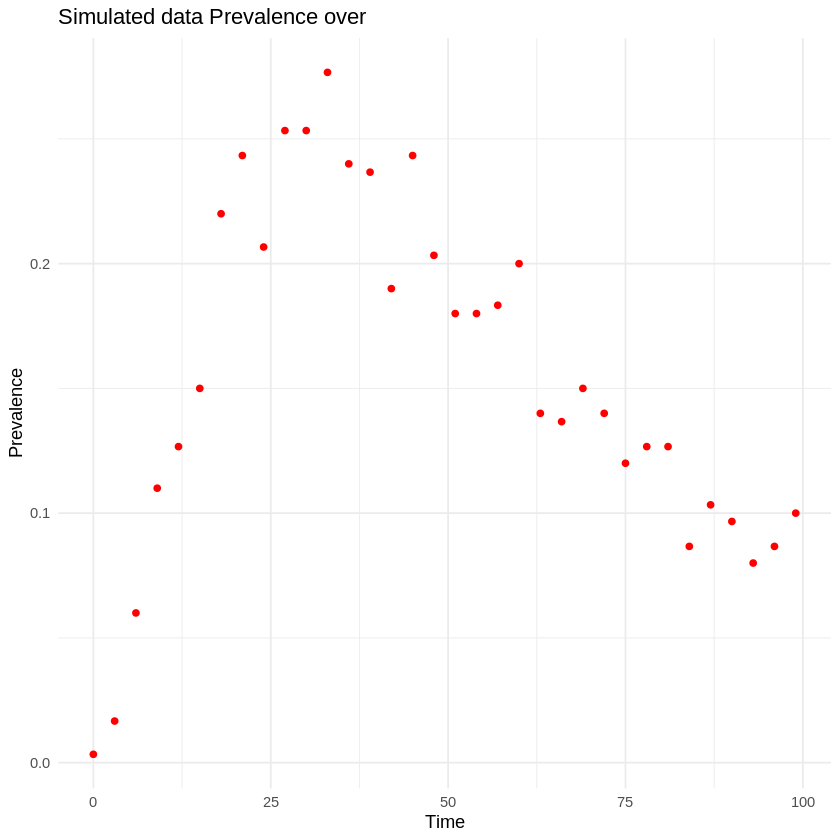

In [262]:
# set.seed(123)  # get the same result

# Simulate data
sampleDates = seq(0, 100, by = 3)#Sample every 3 days
numSamp = rep(300, length(sampleDates))# Number of individuals sampled at each time point
prevalence_at_sample_times <- output_df[output_df$time %in% sampleDates, 'P']
numPositives <- rbinom(length(numSamp), numSamp, prevalence_at_sample_times)
# print(prevalence_at_sample_times)
# print(numPositives/numSamp)

#
simulated_data <- data.frame(
  time = sampleDates,
  numPositives = numPositives,
  numSamp = numSamp,
  P = numPositives/numSamp#prob of getting positive from individuals from 200 individuals
)

# Plot simulated prevalence
ggplot(data = simulated_data, aes(x = time, y = P)) +
  geom_point(color = "red") +
  labs(title = "Simulated data Prevalence over", x = "Time", y = "Prevalence") +
  theme_minimal()

# Data fitting to model

In [263]:
# Negative log-likelihood function
neg_log_likelihood <- function(params) {
  # Solve the model with current parameters
  output_df = simEpidemic(initial_state, times, seirv_model, params)
  # Extract simulated data (the prevalence)
  P_sim <- output_df$P[output_df$time %in% simulated_data$time]

  # Compute the negative log-likelihood
  log_likelihood <- sum(dbinom(simulated_data$numPositives,
                           simulated_data$numSamp,
                           P_sim,
                           log=T))
  return(-log_likelihood)
}

In [264]:
# Minimization of the negative log likelihood

# Initial parameter guess
initial_params <- params

# Optimize the parameters
fitted_params <- optim(par = initial_params,
  fn = neg_log_likelihood#,
  # control = list(trace = 3, maxit = 150),
  # method = "SANN"
)

# Print the fitted parameters
print(fitted_params$par)

DLSODA-  At T (=R1), too much accuracy requested  
      for precision of machine..  See TOLSF (=R2) 
In above message, R1 = 43.0071, R2 = nan
 


Warning message in lsoda(y = initial_state, times = timestep, func = model, parms = params):
“Excessive precision requested.  scale up `rtol' and `atol' e.g by the factor 10”
Warning message in lsoda(y = initial_state, times = timestep, func = model, parms = params):
“Returning early. Results are accurate, as far as they go”
Warning message in dbinom(simulated_data$numPositives, simulated_data$numSamp, P_sim, :
“NaNs produced”


DLSODA-  At T (=R1), too much accuracy requested  
      for precision of machine..  See TOLSF (=R2) 
In above message, R1 = 83.5561, R2 = nan
 


Warning message in lsoda(y = initial_state, times = timestep, func = model, parms = params):
“Excessive precision requested.  scale up `rtol' and `atol' e.g by the factor 10”
Warning message in lsoda(y = initial_state, times = timestep, func = model, parms = params):
“Returning early. Results are accurate, as far as they go”
Warning message in dbinom(simulated_data$numPositives, simulated_data$numSamp, P_sim, :
“NaNs produced”


           a            c      beta_AA      beta_TA      beta_TT      beta_AT 
 4.762151047  2.047334111 -2.921295661  1.173808646  1.711286368  1.105939934 
          nu        gamma        delta      epsilon 
 0.120850057  0.108174972  0.003117286  0.018438442 


# Integration with fitted parameters

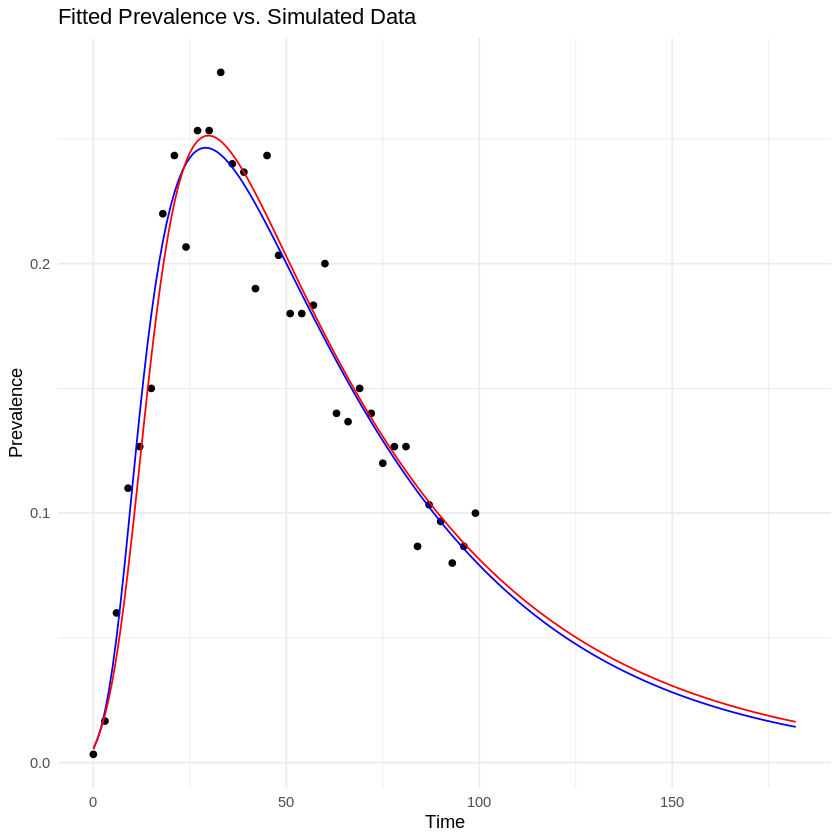

In [265]:
# Solve the model with fitted parameters
fitted_output_df = simEpidemic(initial_state, times, seirv_model, fitted_params$par)
# Plot fitted prevalence against simulated data

colors <- c("Simulated Data" = "blue", "Simulated Prevalence" = "red", "Prevalence" = "orange")
ggplot() +
  geom_point(data = simulated_data, aes(x = time, y = P), color = "black") +
  geom_line(data = fitted_output_df, aes(x = time, y = P), color = "blue") +
  geom_line(data = output_df, aes(x = time, y = P), color = "red") +
  labs(title = "Fitted Prevalence vs. Simulated Data", x = "Time", y = "Prevalence") +
  theme_minimal()

# Intervention

In [336]:
T_interv = 8

In [309]:
f.fn <- function(I, N, x, a = 50){
  ans <- 0
  if (I<x){
    ans <- 0.5
  }
  else{
    ans <- exp(-a*I/N)
  }
  ans
}

In [303]:
# f.fn(output_df$I_A[1], output_df$N_A[1], 20)

numeric(0)

In [332]:
beta_AA <- function(t) ifelse(t < T_interv, 0.3, 0.05)
beta_TA <- function(t) ifelse(t < T_interv, 0.5, 0.1)
beta_TT <- function(t) ifelse(t < T_interv, 1., 0.15)
beta_AT <- function(t) ifelse(t < T_interv, 0.2, 0.1)

In [333]:
seirv_interv_model <- function(t, y, parms){
  with(c(as.list(y), parms), {
    N_A <- S_A + E_A + I_A + R_A + V_A
    N_T <- S_T + E_T + I_T + R_T + V_T
    N <- N_A + N_T
    I <- I_A + I_T
    #background death rate
    ##threshold
    x0 = N*log(2)/a#Risk averse
    y0 = N*log(2)/c#Risk tolerant
    # t_interv = 10
    #Transmission coefficients
    lambda_AA <- beta_AA(t) * exp(-a*I/N) * I_A/N_A;
    lambda_TA <- beta_TA(t) * exp(-c*I/N) *I_T/N_T;
    lambda_TT <- beta_TT(t) *I_T/N_T;
    lambda_AT <- beta_AT(t) *exp(-c*I/N)*I_A/N_A;
    # if (t < T_interv){
    #     lambda_AA <- beta_AA * exp(-a*I/N) * I_A/N_A;
    #     lambda_TA <- beta_TA * exp(-c*I/N) *I_T/N_T;
    #     lambda_TT <- beta_TT*I_T/N_T;
    #     lambda_AT <- beta_AT*exp(-c*I/N)*I_A/N_A;
    # }
    # else{
    #     lambda_AA <- beta_AA * 0.5*exp(-a*I/N) * I_A/N_A;
    #     lambda_TA <- beta_TA * 0.5*exp(-c*I/N) *I_T/N_T;
    #     lambda_TT <- beta_TT*I_T/N_T*0.5;
    #     lambda_AT <- beta_AT*exp(-c*I/N)*I_A/N_A*0.5;
    # }
    # else{
    #     lambda_AA <- beta_AA * f.fn(I,N, x0, a)* I_A/N_A;
    #     lambda_TA <- beta_TA * f.fn(I,N, y0, c)*I_T/N_T;
    #     lambda_TT <- beta_TT*I_T/N_T * 0.5 ;
    #     lambda_AT <- beta_AT* f.fn(I,N, y0, c)*I_A/N_A;
    # }
    #
    # risk averse
    dS_Adt <- - (nu + lambda_AA + lambda_TA)*S_A
    dE_Adt <- (lambda_AA + lambda_TA) * S_A - gamma * E_A
    dI_Adt <- gamma * E_A - (delta + epsilon) * I_A
    dR_Adt <- delta * I_A
    dV_Adt <- nu * S_A #- tau * V_A

    #risk tolerant
    dS_Tdt <- - ( + nu + lambda_TT + lambda_AT)*S_T
    dE_Tdt <- (lambda_TT + lambda_AT) * S_T - gamma * E_T
    dI_Tdt <- gamma * E_T - (delta + epsilon) * I_T
    dR_Tdt <- delta * I_T
    dV_Tdt <- nu * S_T #- tau * V_T
    # return a list
    return(list(c(dS_Adt, dE_Adt, dI_Adt, dR_Adt, dV_Adt, dS_Tdt, dE_Tdt, dI_Tdt, dR_Tdt, dV_Tdt)))
  })
}

In [338]:
# Simulation

ts_seirv_without_interv <- simEpidemic(initial_state, times, seirv_model, fitted_params$par)

ts_seirv_with_interv <- simEpidemic(initial_state, times, seirv_interv_model, fitted_params$par)

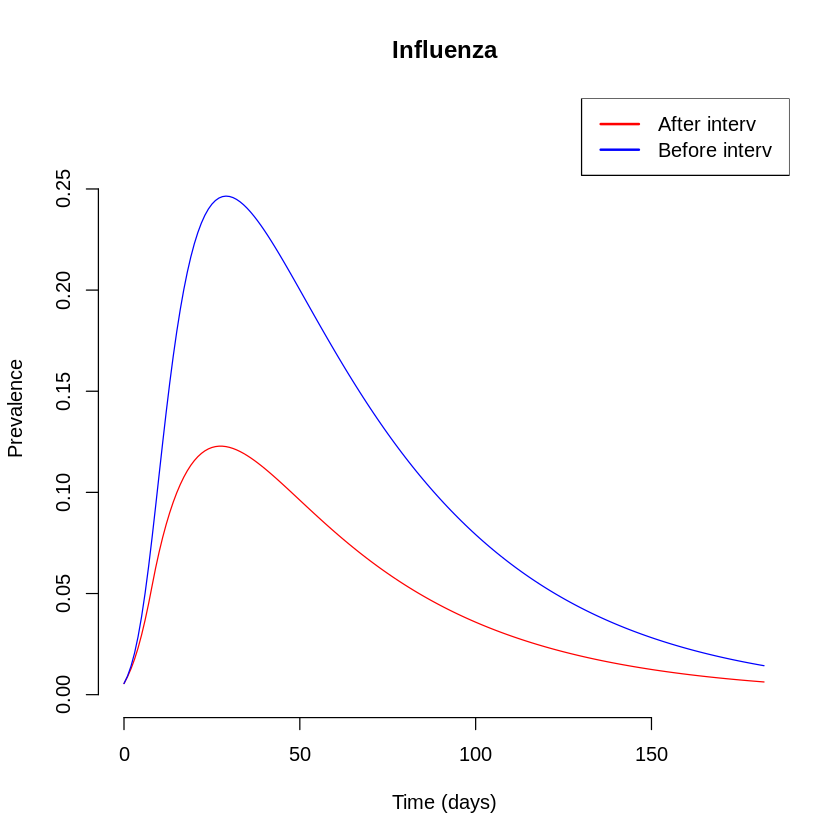

In [339]:
# Plotting

#### Infected
max_y <- max(c(max(ts_seirv_with_interv$P), max(ts_seirv_without_interv$P)))
plot(ts_seirv_with_interv$time,               # Time on the x axis
     ts_seirv_with_interv$P,                  # Number infected (I) on the y axis
     xlab = "Time (days)",     # Label the x axis
     ylab = "Prevalence",  # Label the y axis
     main = "Influenza",    # Plot title
     xlim = c(0, max(ts_seirv_with_interv$time)),           #
     ylim = c(0, max_y*1.15),
     col="red",
     type = "l",                # Use a line plot
     bty = "n")                 # Remove the box around the plot
lines(ts_seirv_with_interv$time, ts_seirv_without_interv$P, col="blue")
legend("topright", legend = c("After interv", "Before interv"), col = c("red", "blue"), lwd = 2)